<a href="https://colab.research.google.com/github/LokiAndere/MIARFID-VPC-2019-20/blob/master/archivador_family.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#in the 90s and the beginings of 00s the nets with
#general structure idea of encoder ==> decoder existed
#back then we called them "archivators"

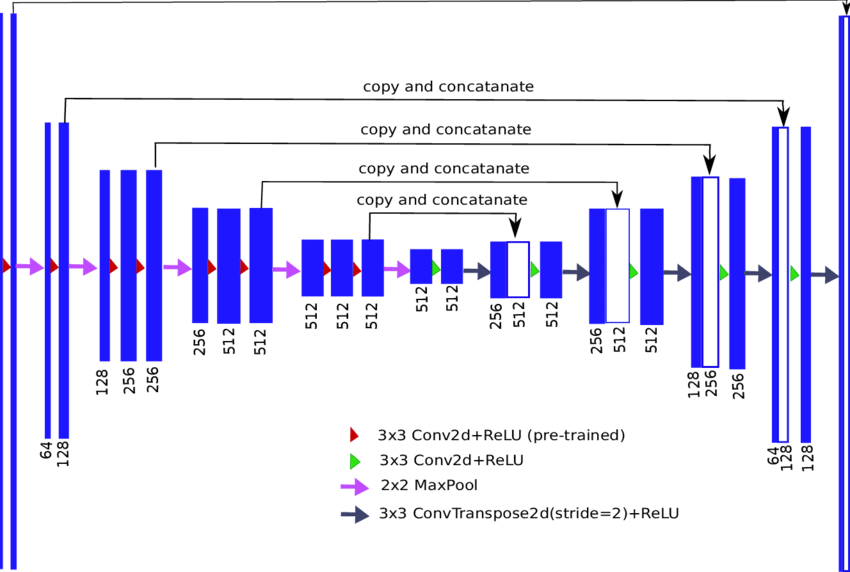

In [0]:
#even though there was no convolution in the theory of artificial neural networks
#and many more technics by the way
#the idea of this name was as follows:
#we gave an image as an input, pixel by pixel in a row
#we trained a mirrored network that first goes down with dimentions
#and then rises in the mirror way again to original dimention
#it is trained to have exact same output as input
#input=output
#then we save only a half of network: the layer sizes from little to original
#weights of those layer's connections and inputs of the smallest layer
#vuala we have an image archivator from a ≈20+ time capsule

In [0]:
import keras
import keras.backend as BCKN
from keras.models import Model
from keras.layers import Input, Concatenate, Add, Lambda
from keras.layers import Conv2D, UpSampling2D
from keras.layers import Conv3D, Conv3DTranspose
from keras.layers import MaxPooling2D
from keras.layers import ReLU, PReLU, Softmax
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


**UNet**

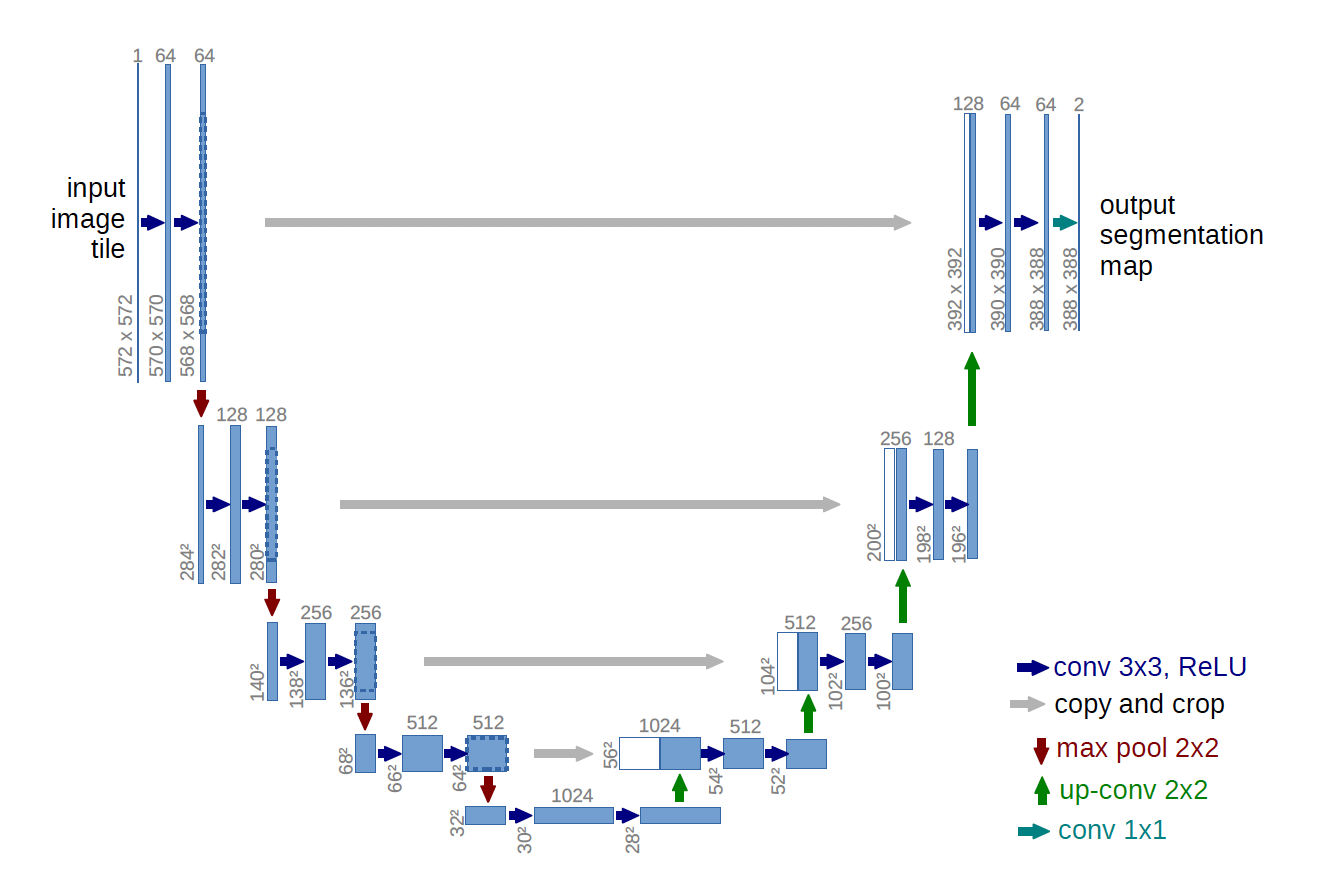

In [0]:
def UNet(features=64, steps=4, n_classes=3):
  
  #features are beginning filters, they rise in 2**n rate
  #steps are steps into thining the net, one should 
  #take in account the ratio of those two

  #it is hard to invent good automatization for this kind of net
  shape=572, 572, 1

  def CR(model, filters):
    model = Conv2D(filters, 3)(model)
    model = ReLU() (model)
    return model

  #squeeze block
  def SQB(model, filters):
    model = CR(model, filters)
    model = CR(model, filters)
    return model

  #down right
  def DR(model, filters):
    model=CR(model, filters)
    save=CR(model, filters)
    model = MaxPooling2D(2, strides=2, padding='same')(save)
    return model, save

  #copy crop connect
  def CCC(model, inside):
    modelH = BCKN.int_shape(model)[1]
    modelV = BCKN.int_shape(model)[2]
    insideH = BCKN.int_shape(inside)[1]
    insideV = BCKN.int_shape(inside)[2]
    medH = (insideH-modelH)//2
    medV = (insideV-modelV)//2
    inside = Lambda(lambda model: model[:, medH: insideH-medH, medV: insideV-medV, :])(inside)
    model = Concatenate()([inside, model])
    return model

  #up connect
  def UC(model, filters, inside):
    model = UpSampling2D()(model)
    model = Conv2D(filters, 2, padding='same')(model)
    model = CCC(model, inside)
    model = SQB(model, filters)
    return model
  
  first = Input(shape)
  model = first
  
  #squeeze list
  s_list = []
  for n in range(steps+1):
    model, inside = DR(model, (2**n)*features)
    s_list.append(inside)
  model = s_list.pop()
  
  for k in reversed(range(steps)):
    model = UC(model, (2**k)*features, s_list[k])
  
  last = Conv2D(n_classes, 1)(model)
  model = Model(first, last)
  
  return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 572, 572, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 570, 570, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 570, 570, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 568, 568, 64) 36928       re_lu_1[0][0]                    
____________________________________________________________________________________________

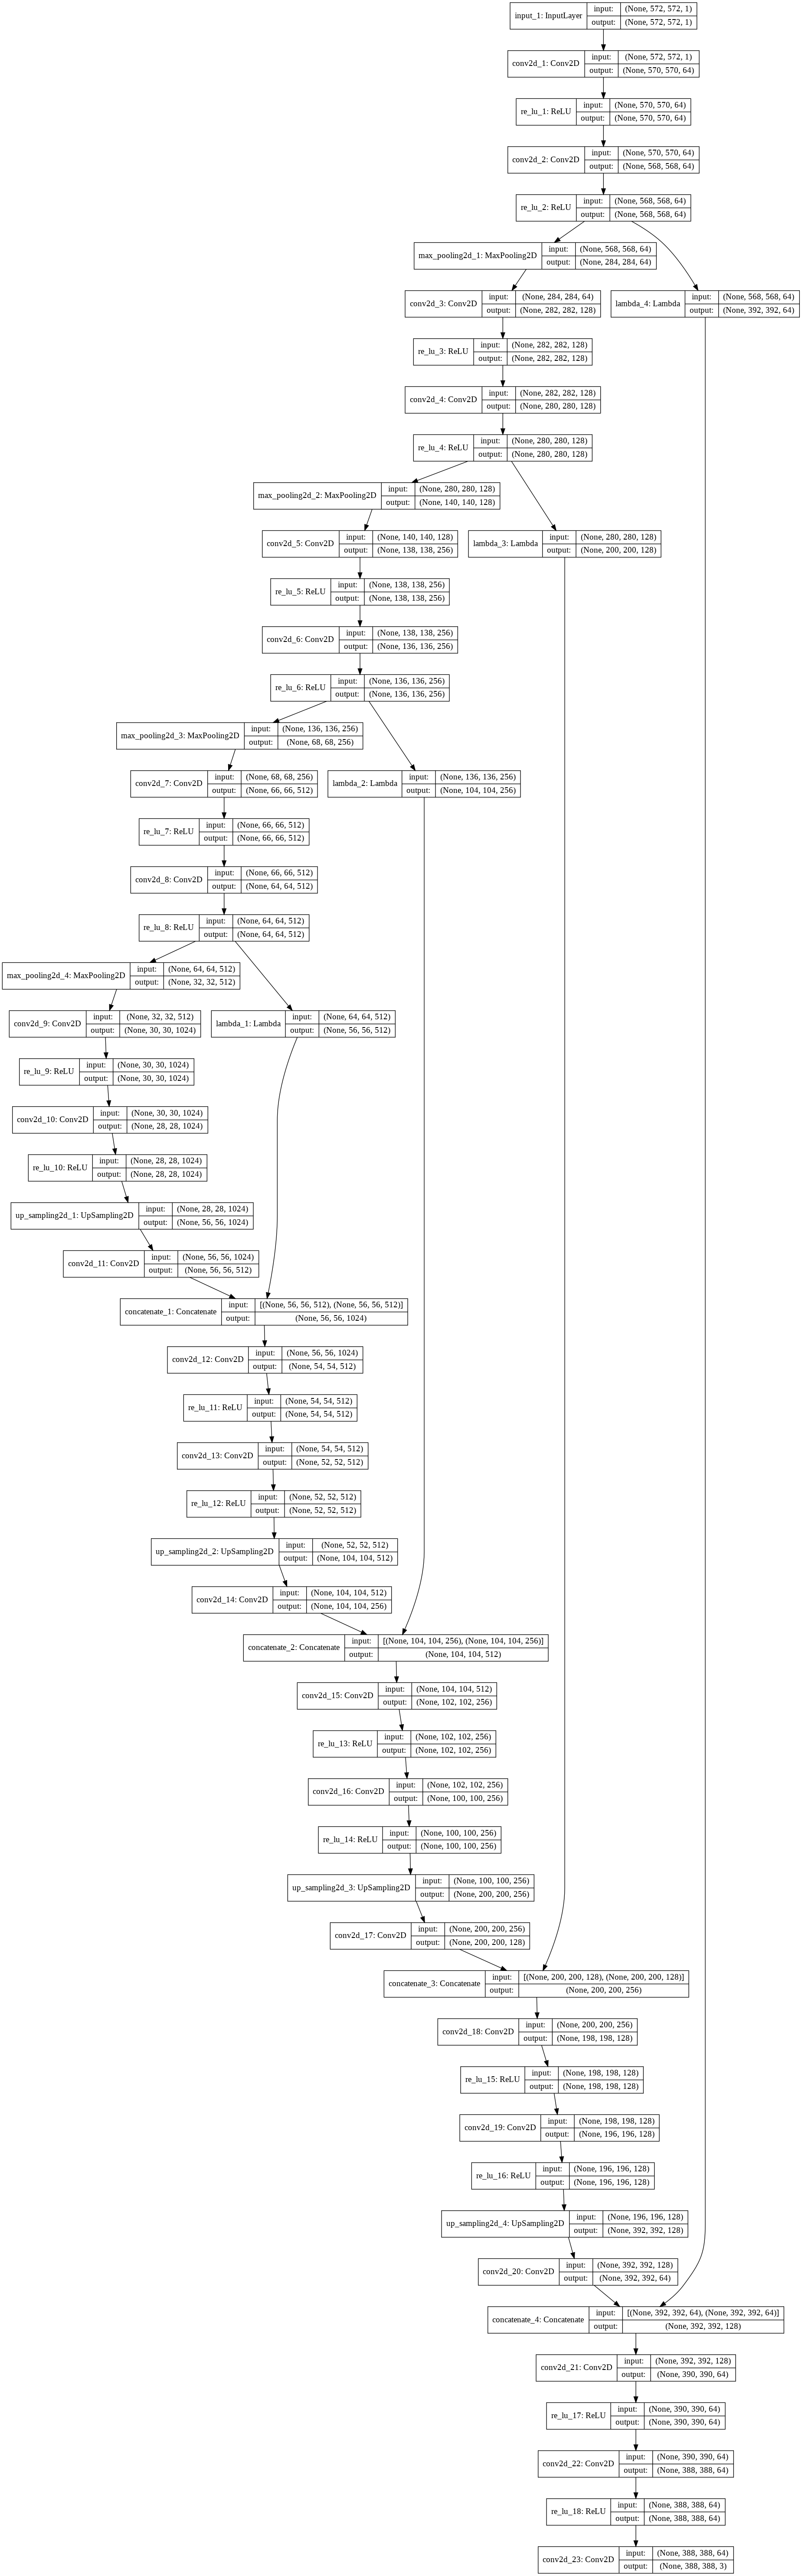

In [0]:
BCKN.clear_session()
model = UNet()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**VNet**

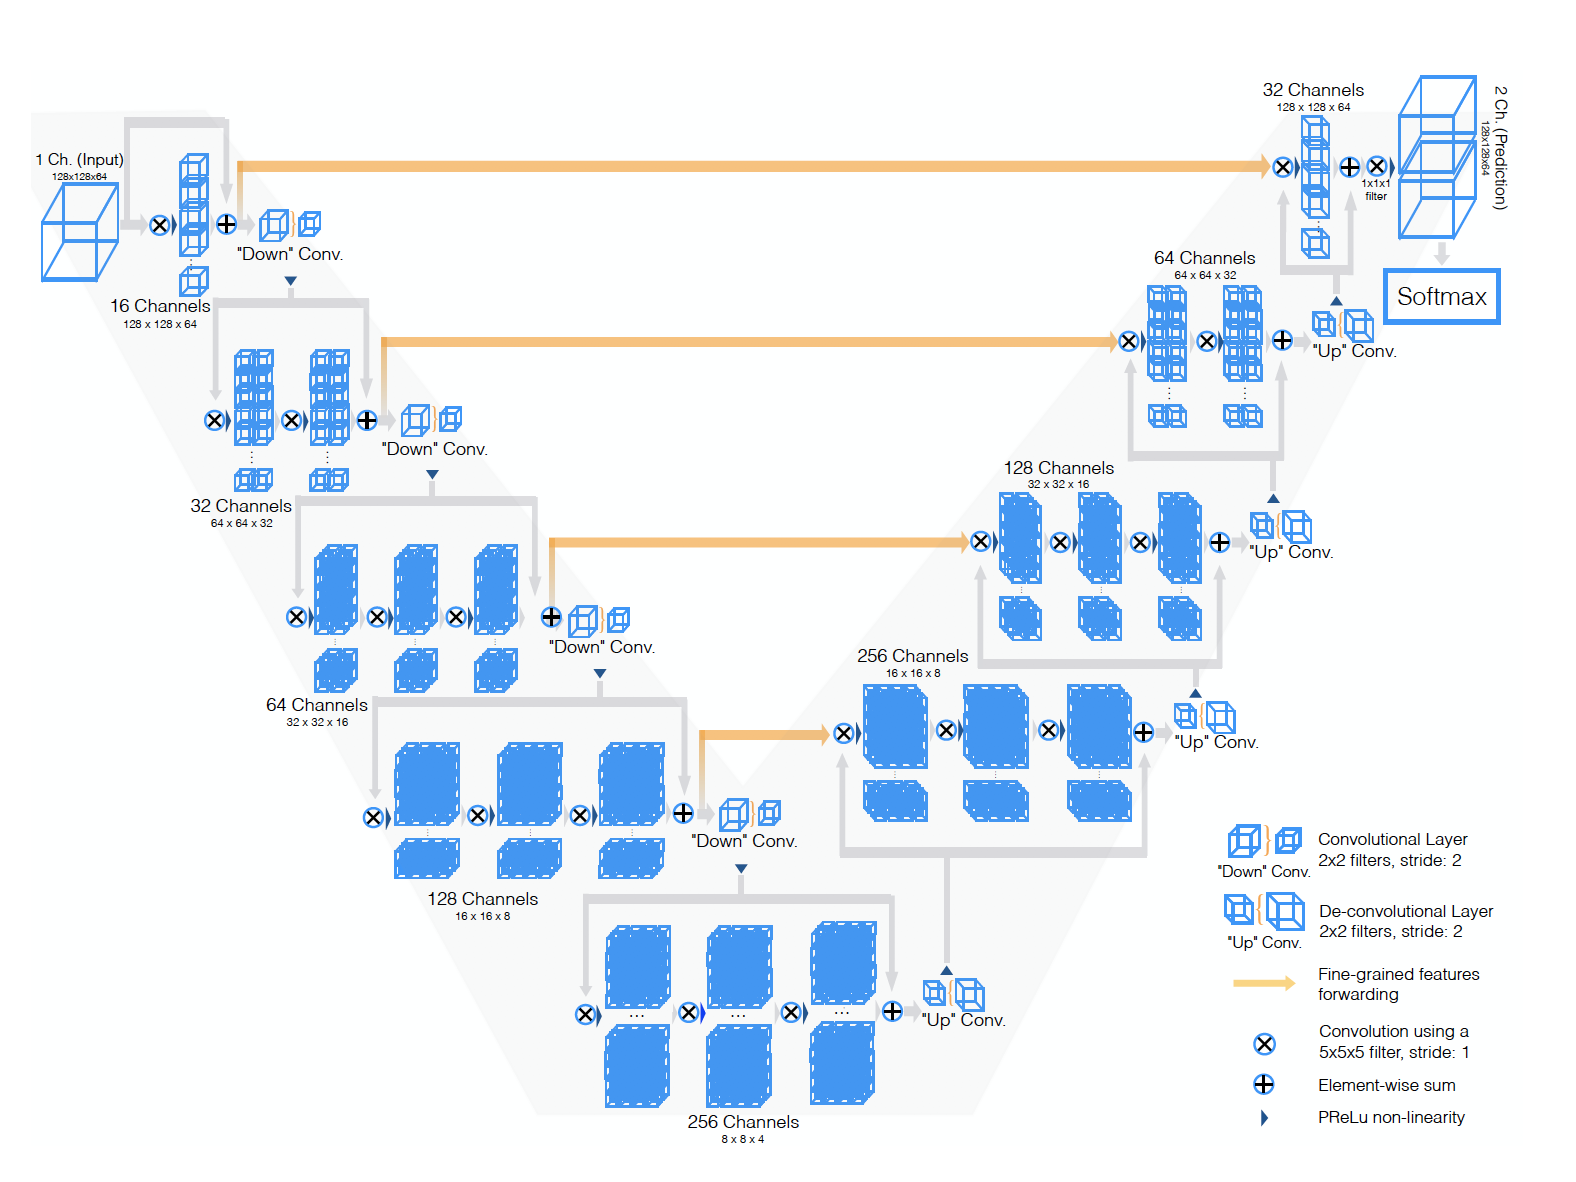

In [0]:
def VNet(shape=(128,128,64), n_classes=3):
  #3d convolution hm...
  #this one is for later
  first = Input(shape)
  model = Conv2D(64, 11)(first)
  last = Conv2D(n_classes, 1)(model)
  model = Model(first, last)
  
  return model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 118, 64)      495680    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 118, 3)       195       
Total params: 495,875
Trainable params: 495,875
Non-trainable params: 0
_________________________________________________________________


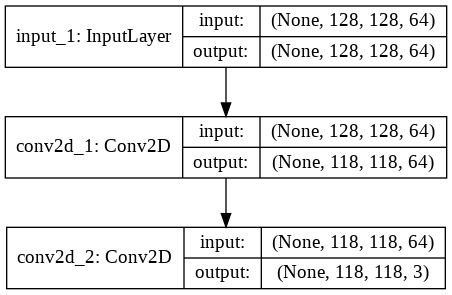

In [0]:
BCKN.clear_session()
model = VNet()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)